# Example
"Spectral Analysis for physical applications Multitaper and Cnventional Univariate Techniques", Donald B. Percival and Andrew T. Walden


In [1]:
from scipy.signal import lfilter
import math
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

from mt_harmonic.multitaper import MultiTaper_Periodogram #適宜変更


A unique taper of eigenvalues (>=0.90) was selected. K=7


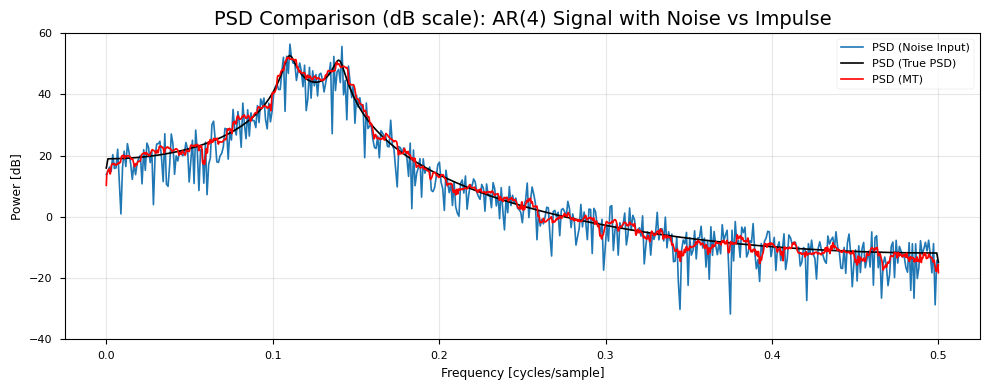

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, windows

# AR(4)係数（AR model coefficients）
ar_coeffs = np.array([2.7607, -3.8106, 2.6535, -0.9238])
A = np.r_[1, -ar_coeffs]  # AR多項式（AR polynomial）
fs = 1.0                  # サンプリング周波数（Sampling frequency）
npts = 1024               # サンプル数（Number of samples）
rng = np.random.default_rng(42)  # 乱数生成器（Random number generator）

# ノイズ付きAR信号生成（Generate noisy AR signal）
sigma = 0.1               # ノイズ標準偏差（Noise standard deviation）
c = 20.0                  # スケーリング係数（Scaling factor）
epsilon = rng.normal(0, sigma, npts)  # ホワイトノイズ（White noise）
x_noise = lfilter([1.0], A, epsilon) * c  # ARフィルタ適用（Apply AR filter）

# FFTによるPSD推定（Estimate PSD using FFT）
nfft = 1024
freqs = np.fft.rfftfreq(nfft, d=1/fs)  # 片側周波数軸（One-sided frequency axis）
X = np.fft.rfft(x_noise, n=nfft)       # 実信号用FFT（FFT for real signal）
psd_noise = (np.abs(X)**2) / (fs * npts)
psd_noise[1:-1] *= 2  # DCとNyquist以外を2倍補正（Double non-DC/Nyquist components）

# ARモデルから理論PSD計算（Compute theoretical PSD from AR model）
omega = 2*np.pi*freqs  # 角周波数（Angular frequency）

Az = (A[0]
      + A[1]*np.exp(-1j*omega)
      + A[2]*np.exp(-1j*2*omega)
      + A[3]*np.exp(-1j*3*omega)
      + A[4]*np.exp(-1j*4*omega))  # AR多項式の周波数応答（Frequency response of AR polynomial）

var_eff = (sigma**2) * (c**2)  # 有効分散（Effective variance）
psd_true = var_eff / (np.abs(Az)**2)
psd_true[1:-1] *= 2  # DCとNyquist以外を2倍補正（Double non-DC/Nyquist components）

# マルチターパー法によるPSD推定（Multitaper PSD estimation）
MT_psd = MultiTaper_Periodogram(NW=4, K=8, nfft=2**12)  # 時間帯域幅NWとターパー数K（Time-bandwidth NW and number of tapers K）
MT_psd.MT_Spec(x_noise, fs)  # PSD推定実行（Execute PSD estimation）

# dBスケールに変換（Convert to dB scale）
psd_noise_db = 10 * np.log10(psd_noise)
Smt_db = 10 * np.log10(MT_psd.Smt)
psd_true_db = 10 * np.log10(psd_true)

# プロット（Plotting）
plt.style.use('seaborn-v0_8-paper')  # スタイル設定（Set plot style）
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(freqs, psd_noise_db, label='PSD (Noise Input)',  lw=1.2)  # ノイズ信号のPSD（PSD of noisy signal）
ax.plot(freqs, psd_true_db, label='PSD (True PSD)',c='k',  lw=1.2)  # 理論PSD（Theoretical PSD）
ax.plot(MT_psd.f, Smt_db, label='PSD (MT)',c='r',  lw=1.2)  # マルチターパーPSD（Multitaper PSD）

ax.set_title('PSD Comparison (dB scale): AR(4) Signal with Noise vs Impulse', fontsize=14)
ax.set_xlabel('Frequency [cycles/sample]')  
ax.set_ylabel('Power [dB]')                
ax.grid(True, alpha=0.3)
ax.set_ylim(-40,60)
ax.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Figure 505. Analysis of Willamette River data, part 1 (a).

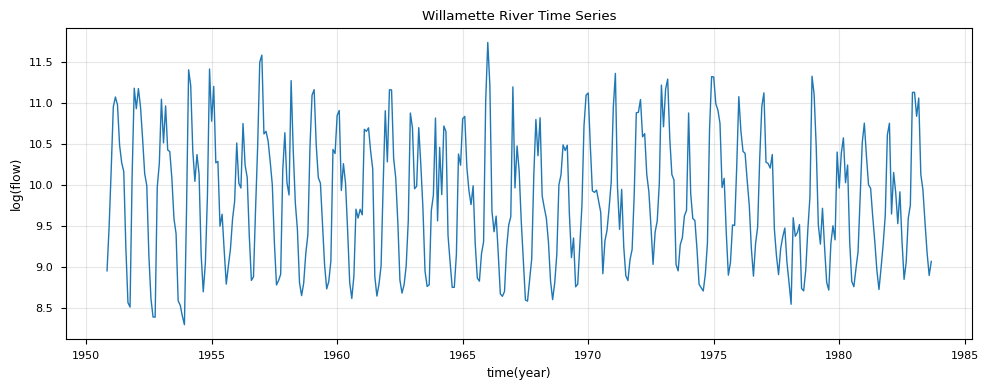

In [3]:
Willamette_data = np.loadtxt("https://faculty.washington.edu/dbp/DATA/Willamette.dat", comments="C")
# サンプル数と時間軸の設定（Set number of samples and time axis）
npts = len(Willamette_data)        # データ点数（Number of data points）= 395
start_year = 1950 + 10/12          # 開始時刻：1950年10月（Start time: Oct 1950）≈ 1950.83
dt = 1/12                          # 1サンプル = 1ヶ月（1 sample = 1 month）= 1/12年
time_axis = start_year + np.arange(npts) * dt  # 時間軸（Time axis）

# プロット（Plotting）
plt.style.use('seaborn-v0_8-paper')  
plt.figure(figsize=(10,4))
plt.plot(time_axis, Willamette_data, lw=1)  
plt.title("Willamette River Time Series")   
plt.xlabel("time(year)")                    
plt.ylabel("log(flow)")                     
plt.grid(True, alpha=0.3)                   
plt.tight_layout()
plt.show()


## Figure 512. Analysis of Willamette River data, part 4.

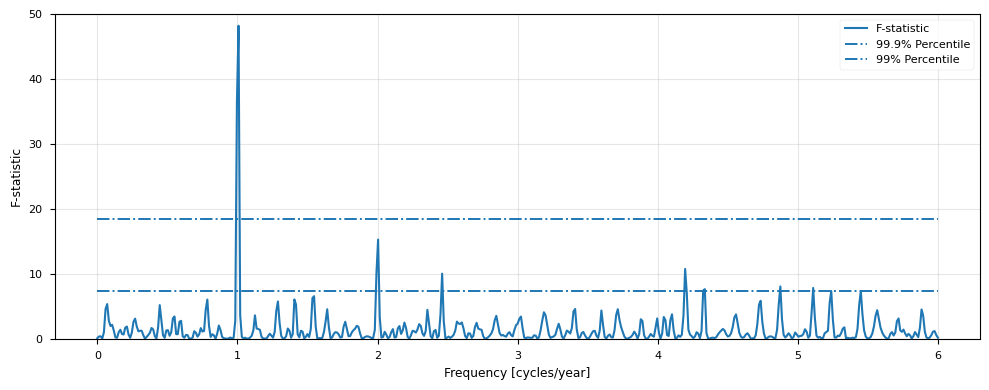

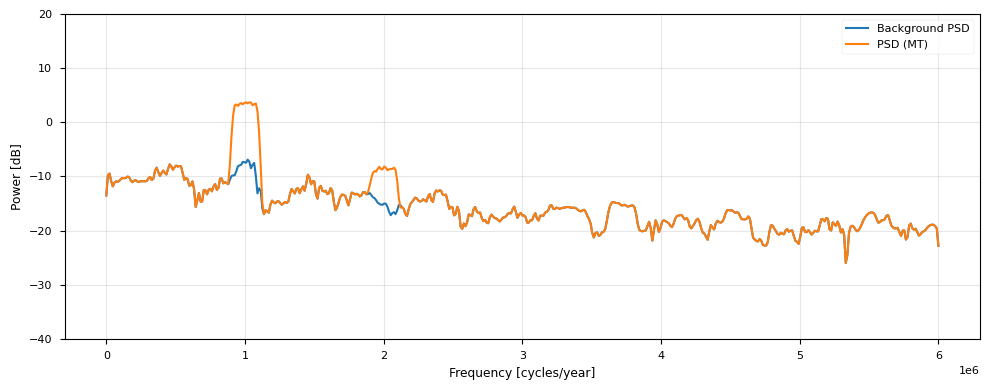

In [4]:
# マルチターパーPSD推定とF検定（Multitaper PSD estimation and harmonic F-test）
MT_psd = MultiTaper_Periodogram(NW=4, K=5, nfft=1024)  # 時間帯域幅NW=4、ターパー数K=5、FFT長1024（Time-bandwidth NW=4, number of tapers K=5, FFT length=1024）
MT_psd.MT_Spec(Willamette_data, fs=1/dt)               # サンプルレート = 1ヶ月 = 1/12年（Sampling rate = 1 sample/month = 1/12 year）
MT_psd.Harmonic_Ftest(p_level=0.005)                   # 有意水準0.5%でF検定（Harmonic F-test at 0.5% significance level）

# PSDのdBスケール変換（Convert PSD to dB scale）
Smt_db = 10 * np.log10(MT_psd.Smt)                     # マルチターパーPSD（Multitaper PSD）
Re_Smt_db = 10 * np.log10(np.maximum(MT_psd.re_psd, 1e-20))  # 背景PSD（Background PSD）※ゼロ除去のため1e-20で下限（Avoid log(0) by lower bound 1e-20）

# # F統計量のプロット
plt.style.use('seaborn-v0_8-paper')#'mpl20': 'default', 'mpl15': 'classic'
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot()
ax.plot(MT_psd.f, MT_psd.F_stat[0, :], '-', label='F-statistic', alpha=1,  lw=1.5)
# ax.hlines(MT_psd.F_crit, MT_psd.f[0], MT_psd.f[-1], linestyles="-.", color='green', label='99.9% Percentile')
ax.hlines(MT_psd.F_999, MT_psd.f[0], MT_psd.f[-1], linestyles="-.", label='99.9% Percentile')
ax.hlines(MT_psd.F_99, MT_psd.f[0], MT_psd.f[-1], linestyles="-.",  label='99% Percentile')
ax.set_ylabel('F-statistic')
ax.set_xlabel('Frequency [cycles/year]')
ax.set_ylim(0, 50)
ax.legend()
fig.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

# プロット
plt.style.use('seaborn-v0_8-paper')#'mpl20': 'default', 'mpl15': 'classic'
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(MT_psd.f*1e6, Re_Smt_db[0,:], '-', label='Background PSD', alpha=1,  lw=1.5)
ax.plot(MT_psd.f*1e6, Smt_db, label='PSD (MT)',  lw=1.5)
ax.set_xlabel('Frequency [cycles/year]')
ax.set_ylabel('Power [dB]')
ax.grid(True, alpha=0.3)
ax.set_ylim(-40,20)
ax.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Load sediment core data
Number of points and dt  156 4930


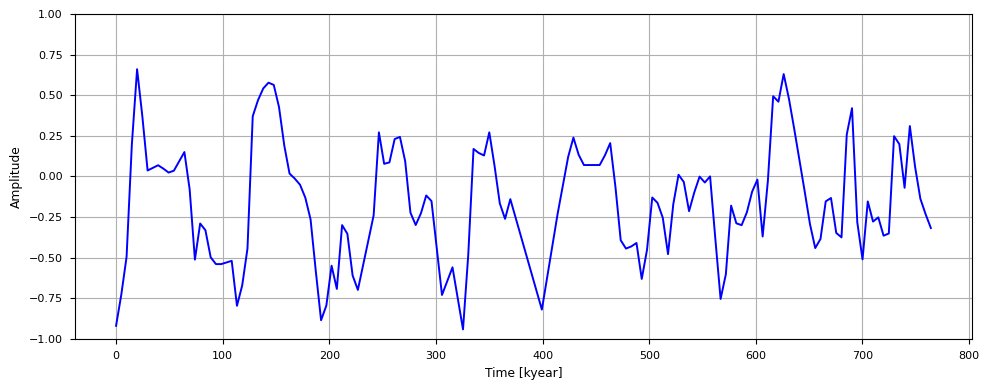

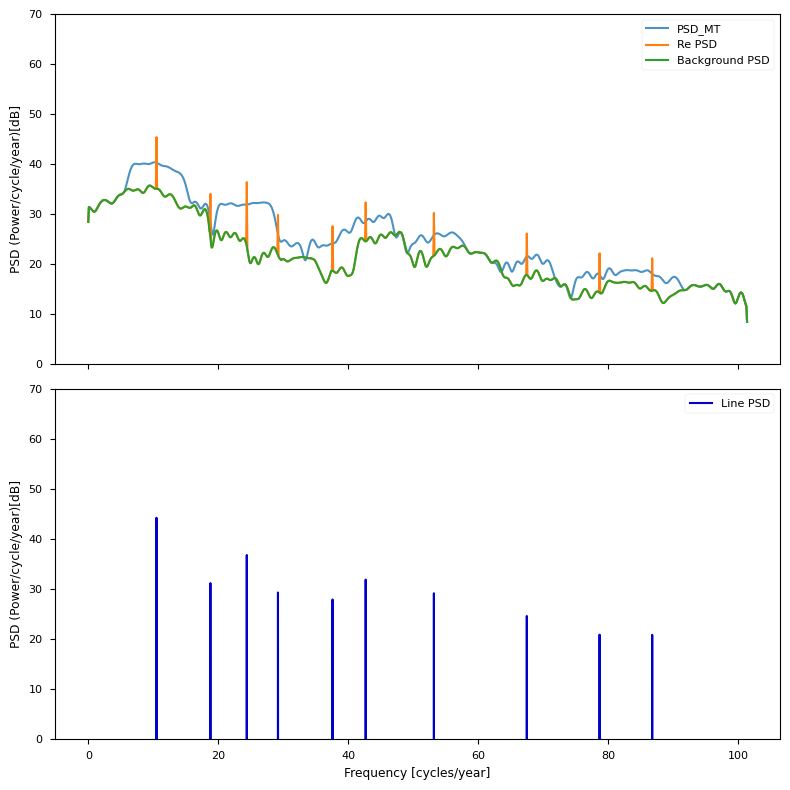

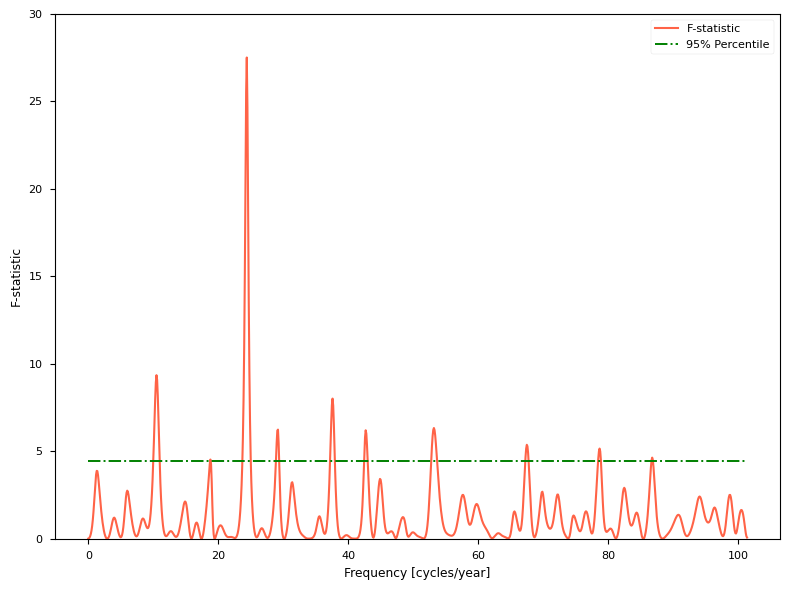

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def get_data(fname):
   
    if (fname.find("v22")>-1):
        url = 'https://zenodo.org/record/6025794/files/v22_174_series.dat?download=1'
    elif (fname.find("hhe.dat")>-1):
        url = 'https://zenodo.org/record/6025794/files/sgc_vmm_hhe.dat?download=1'
    elif (fname.find("sgc_vmm.dat")>-1):
        url = 'https://zenodo.org/record/6025794/files/sgc_vmm.dat?download=1'
    elif (fname.find("sgc_surf")>-1):
        url = 'https://zenodo.org/record/6025794/files/sgc_surf.dat?download=1'
    elif (fname.find("sgc_mesetas")>-1):
        url = 'https://zenodo.org/record/6025794/files/sgc_mesetas.dat?download=1'
    elif (fname.find("PASC")>-1):
        url = 'https://zenodo.org/record/6025794/files/PASC.dat?download=1'
    elif (fname.find("_src")>-1):
        url = 'https://zenodo.org/record/6025794/files/mesetas_src.dat?download=1'
    elif (fname.find("crisanto")>-1):
        url = 'https://zenodo.org/record/6025794/files/crisanto_mesetas.dat?download=1'
    elif (fname.find("akima")>-1):
        url = 'https://zenodo.org/record/6025794/files/asc_akima.dat?download=1'
    elif (fname.find("ADO")>-1):
        url = 'https://zenodo.org/record/6025794/files/ADO.dat?download=1'
    else:
        data = -1
        
    data = np.loadtxt(url)
    
    return data

# データ読み込み (data load)
x = get_data('v22_174_series.dat')
npts = np.shape(x)[0]
dt   = 4930  # サンプリング間隔 [years]
t    = np.arange(npts) * dt
print('Load sediment core data')
print('Number of points and dt ', npts, dt)

# Plot signal
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot()
ax.plot(t / 1e3, x, label="AM Signal", color='b')
ax.set_xlabel("Time [kyear]")   
ax.set_ylabel("Amplitude")
ax.set_ylim(-1.0,1.0)
ax.grid()
plt.tight_layout()
plt.show()

# サンプリング周波数 [cycles/year]
fs = 1.0 / dt

# マルチターパーPSD推定とF検定（Multitaper PSD estimation and harmonic F-test）
MT_psd = MultiTaper_Periodogram(NW=4, K=5, nfft=2028)
MT_psd.MT_Spec(x, fs)                 # ← fs = 1/dt を渡す
MT_psd.Harmonic_Ftest(p_level=0.05)

Smt_db = 10 * np.log10(MT_psd.Smt)
Re_Smt_db = 10 * np.log10(np.maximum(MT_psd.re_psd, 1e-20))

# Plot
plt.style.use('seaborn-v0_8-paper')#'mpl20': 'default', 'mpl15': 'classic'
fig, axes = plt.subplots(2, 1, figsize=(8,8), sharex=True)

# PSD_MTと再構成PSD（Multitaper PSD and reconstructed PSD）
ax = axes[0]
ax.plot(MT_psd.f*1e6, Smt_db, '-', label='PSD_MT', alpha=0.8,  lw=1.5)   # マルチターパー推定PSD（Multitaper estimated PSD）
ax.plot(MT_psd.f*1e6, Re_Smt_db[2, :], '-', label='Re PSD', alpha=1,  lw=1.5)  # 再構成されたPSD（Reconstructed PSD）
ax.plot(MT_psd.f*1e6, Re_Smt_db[0, :], '-', label='Background PSD', alpha=1, lw=1.5)  # 背景PSD（Background PSD）
ax.set_ylabel('PSD (Power/cycle/year)[dB]')
ax.set_ylim(0,70)
ax.legend()

# 線成分スペクトルのみ（Line component spectrum only）
ax = axes[1]
ax.plot(MT_psd.f*1e6, Re_Smt_db[1, :], '-', label='Line PSD', alpha=1, c='mediumblue', lw=1.5)  # 線成分PSD（Line component PSD）
ax.set_ylabel('PSD (Power/cycle/year)[dB]')
ax.set_xlabel('Frequency [cycles/year]')
ax.set_ylim(0,70)
ax.legend()
fig.tight_layout()
plt.show()

# F統計量のプロット（Plot of F-statistics）
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.plot(MT_psd.f*1e6, MT_psd.F_stat[0, :], '-', label='F-statistic', alpha=1, c='tomato', lw=1.5)  # F統計量（F-statistic）
ax.hlines(MT_psd.F_crit, MT_psd.f[0]*1e6, MT_psd.f[-1]*1e6, linestyles="-.", color='green', label='95% Percentile')  # 95%臨界値（95% critical value）
ax.set_ylabel('F-statistic')
ax.set_xlabel('Frequency [cycles/year]')
ax.set_ylim(0, 30)
ax.legend()
fig.tight_layout()
plt.show()
